<a href="https://colab.research.google.com/github/rraghavkaushik/Image-to-Image-Translation/blob/main/Image_to_Image_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import matplotlib.pyplot as plt
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, Conv2DTranspose
from keras.utils import plot_model

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 256, 256, 6)          0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 128, 128, 256)        24832     ['concatenate[0][0]']     

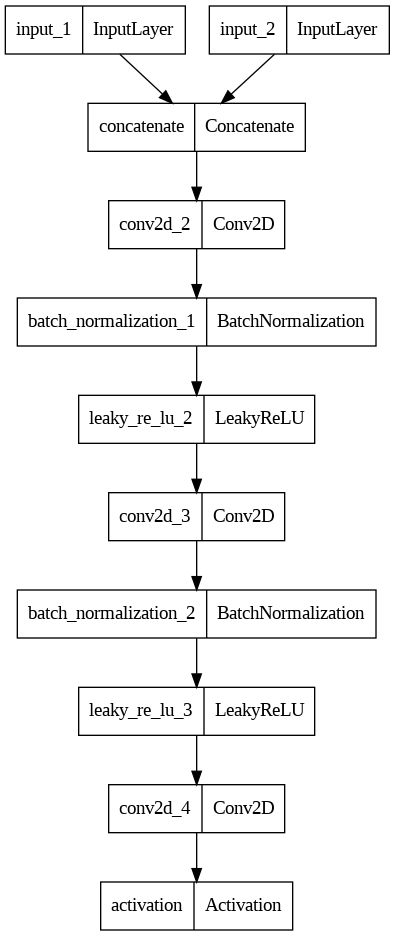

In [2]:
def discriminator_defn(img_size):
  wt = RandomNormal(stddev = 0.02)
  src_img = Input(shape = img_size)
  target_img = Input(shape = img_size)
  ''' concatenating channel wise'''
  conc_img = Concatenate()([src_img, target_img])

  ''' Discriminator architechture described in the paper :
    C64-C128-C256-C512
    After the last layer, a convolution is applied to map to
    a 1-dimensional output, followed by a Sigmoid function.
    As an exception to the above notation, BatchNorm is not
    applied to the first C64 layer. All ReLUs are leaky, with
    slope 0.2.'''


  l = Conv2D(64, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(conc_img)
  l = LeakyReLU(alpha = 0.2)(l)

  l = Conv2D(128, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(conc_img)
  l = BatchNormalization()(l)
  l = LeakyReLU(alpha = 0.2)(l)

  l = Conv2D(256, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(conc_img)
  l = BatchNormalization()(l)
  l = LeakyReLU(alpha = 0.2)(l)

  l = Conv2D(512, (4, 4), padding = 'same', kernel_initializer = wt)(l)
  l = BatchNormalization()(l)
  l = LeakyReLU(alpha = 0.2)(l)

  l = Conv2D(1, (4, 4), padding = 'same', kernel_initializer = wt)(l)
  output = Activation('sigmoid')(l)

  model = Model(inputs = [src_img, target_img], outputs = output)
  model.summary()
  model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999), metrics = ['accuracy'])
  return model

disc_model = discriminator_defn((256, 256, 3))
# plt.imshow(disc_model)
plot_model(disc_model)

In [3]:
''' encoder-decoder architechture as described in the paper:
    encoder:
    C64-C128-C256-C512-C512-C512-C512-C512
    decoder:
    CD512-CD512-CD512-C512-C256-C128-C64
    All ReLUs in the encoder are leaky, with slope 0.2, while
    ReLUs in the decoder are not leaky '''

def encoder(layer, n, batch_norm = True):
  wt = RandomNormal(stddev = 0.02)
  l = Conv2D(n, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(layer)
  if batch_norm:
    l = BatchNormalization()(l, training = True)
  l = LeakyReLU(alpha = 0.02)(l)
  return l

def decoder(layer, skip, n, dropout = True):
  wt = RandomNormal(stddev = 0.02)
  l = Conv2DTranspose(n, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(layer)
  l = BatchNormalization()(l, training = True)
  if dropout:
    l = Dropout(0.5)(l, training = True)
  l = Concatenate()([l , skip])
  l = Activation('relu')(l)
  return l

def generator(img_size):
  wt = RandomNormal(stddev = 0.02)
  src_img = Input(shape = img_size)

  l1 = encoder(src_img, 64, batch_norm = False)
  l2 = encoder(l1, 128)
  l3 = encoder(l2, 256)
  l4 = encoder(l3, 512)
  l5 = encoder(l4, 512)
  l6 = encoder(l5, 512)
  l7 = encoder(l6, 512)

  b = Conv2D(512, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(l7)
  b = Activation('relu')(b)

  d1 = decoder(b, l7, 512)
  d2 = decoder(d1, l6, 512)
  d3 = decoder(d2, l5, 512)
  d4 = decoder(d3, l4, 512, dropout = False)
  d5 = decoder(d4, l3, 256, dropout = False)
  d6 = decoder(d5, l2, 128, dropout = False)
  d7 = decoder(d6, l1, 64, dropout = False)

  l = Conv2DTranspose(3, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(d7)
  output = Activation('tanh')(l)

  model = Model(src_img, output)
  model.summary()
  return model

gen = generator((256, 256, 3))
# plot_model(gen, to_file = 'generator.png')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 128, 128, 64)         3136      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 64)         0         ['conv2d_5[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 64, 64, 128)          131200    ['leaky_re_lu_4[0][0]']       
                                                                                            

In [4]:
def GAN(gen, disc, img_size):

  src_img = Input(img_size)
  gen_output = gen(src_img)
  disc_output = disc([src_img, output])
  model = Model(src_img, [disc_output, gen_output])
  optimizer = Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999)
  model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = optimizer, loss_weights = [1, 100])
  return model

def summarize_performance(step, g_model, dataset, n_samples=3):

	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))